In [3]:
# 10.1 FashionMNIST 다운로드
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

print(classes)
print(class_to_idx)

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

print(f"Training Data Size : {len(subset_train_dataset)}")
print(f"Testing Data Size : {len(subset_test_dataset)}")
print(train_dataset[0])

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.9MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Training Data Size : 10000
Testing Data Size : 1000
(<PIL.Image.Image image mode=L size=28x28 at 0x7E7222845250>, 9)


In [4]:
# 10.2 이미지 전처리
import torch
from torchvision import transforms
from transformers import AutoImageProcessor


image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

print(f"size : {image_processor.size}")
print(f"mean : {image_processor.image_mean}")
print(f"std : {image_processor.image_std}")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


size : {'height': 224, 'width': 224}
mean : [0.5, 0.5, 0.5]
std : [0.5, 0.5, 0.5]


In [5]:
# 10.3 ViT 데이터로더 적용
from torch.utils.data import DataLoader


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


train_dataloader = DataLoader(
    subset_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)
valid_dataloader = DataLoader(
    subset_test_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)

batch = next(iter(train_dataloader))
for key, value in batch.items():
    print(f"{key} : {value.shape}")

pixel_values : torch.Size([32, 3, 224, 224])
labels : torch.Size([32])


In [6]:
# 10.4 사전 학습된 ViT 모델
from transformers import ViTForImageClassification


model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
    num_labels=len(classes),
    id2label={idx: label for label, idx in class_to_idx.items()},
    label2id=class_to_idx,
    ignore_mismatched_sizes=True
)

print(model.classifier)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [7]:
# 10.5 패치 임베딩 확인
print(model.vit.embeddings)

batch = next(iter(train_dataloader))
print("image shape :", batch["pixel_values"].shape)
print("patch embeddings shape :",
    model.vit.embeddings.patch_embeddings(batch["pixel_values"]).shape
)
print("[CLS] + patch embeddings shape :",
    model.vit.embeddings(batch["pixel_values"]).shape
)

ViTEmbeddings(
  (patch_embeddings): ViTPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)
image shape : torch.Size([32, 3, 224, 224])
patch embeddings shape : torch.Size([32, 196, 768])
[CLS] + patch embeddings shape : torch.Size([32, 197, 768])


In [8]:
# 10.6 하이퍼파라미터 설정
from transformers import TrainingArguments


args = TrainingArguments(
    output_dir="../models/ViT-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

In [11]:
# 10.7 매크로 평균 F1 점수
import evaluate
import numpy as np


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1

In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [13]:
# 10.8 ViT 모델 학습
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = ViTForImageClassification.from_pretrained(
        pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="../models/ViT-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-13-14966a68b3d2>:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
Yo

Epoch,Training Loss,Validation Loss,F1
1,0.701600,0.633069,0.886772
2,0.476200,0.475589,0.908526
3,0.416700,0.426518,0.921219


TrainOutput(global_step=1875, training_loss=0.6973154032389323, metrics={'train_runtime': 1064.849, 'train_samples_per_second': 28.173, 'train_steps_per_second': 1.761, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.6973154032389323, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 3.0681734 , -0.6419812 , -0.3343356 , ..., -0.5731831 ,
        -0.3567733 , -0.6080361 ],
       [ 2.0528169 , -0.69184965, -0.22475849, ..., -0.8014118 ,
        -0.83252895, -0.9621997 ],
       [ 2.9940288 , -0.5980767 , -0.13096838, ..., -0.51872545,
        -0.3912144 , -0.57170147],
       ...,
       [-0.5802773 , -0.6388997 , -0.52295536, ...,  0.6555627 ,
         0.33529258,  2.9528754 ],
       [-0.5526087 , -0.38945624, -0.29982167, ...,  0.14398356,
        -0.30734676,  3.388054  ],
       [-0.5230375 , -0.33305565, -0.29799244, ..., -0.27637705,
        -0.14771831,  3.412888  ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

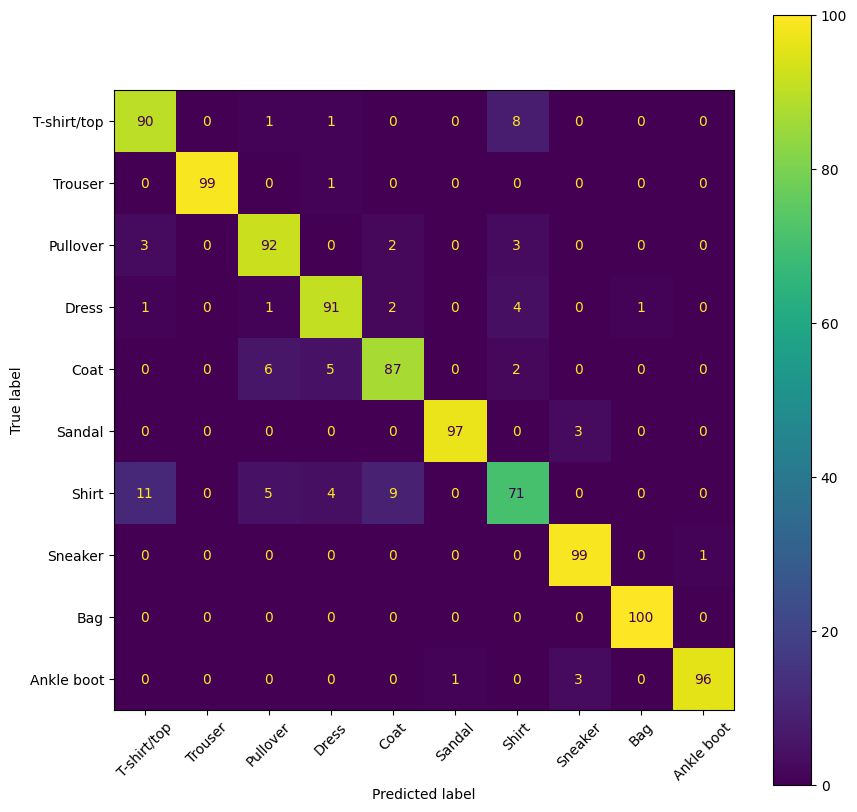

In [14]:
# 10.9 ViT 모델 성능 평가가
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()

In [15]:
# 10.10 상대적 위치 편향 계산산
import torch

window_size = 2
coords_h = torch.arange(window_size)
coords_w = torch.arange(window_size)
coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))
coords_flatten = torch.flatten(coords, 1)
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]

print(relative_coords)
print(relative_coords.shape)

tensor([[[ 0,  0, -1, -1],
         [ 0,  0, -1, -1],
         [ 1,  1,  0,  0],
         [ 1,  1,  0,  0]],

        [[ 0, -1,  0, -1],
         [ 1,  0,  1,  0],
         [ 0, -1,  0, -1],
         [ 1,  0,  1,  0]]])
torch.Size([2, 4, 4])


In [16]:
# 10.11 X, Y축에 대한 위치 행렬
x_coords = relative_coords[0, :, :]
y_coords = relative_coords[1, :, :]

x_coords += window_size - 1  # X축에 대한 3번 연산 과정
y_coords += window_size - 1  # Y축에 대한 3번 연산 과정
x_coords *= 2 * window_size - 1  # 4번 연산 과정
print(f"X축에 대한 행렬:\n{x_coords}\n")
print(f"Y축에 대한 행렬:\n{y_coords}\n")

relative_position_index = x_coords + y_coords  # 5번 연산 과정
print(f"X, Y축에 대한 위치 행렬:\n{relative_position_index}")

X축에 대한 행렬:
tensor([[3, 3, 0, 0],
        [3, 3, 0, 0],
        [6, 6, 3, 3],
        [6, 6, 3, 3]])

Y축에 대한 행렬:
tensor([[1, 0, 1, 0],
        [2, 1, 2, 1],
        [1, 0, 1, 0],
        [2, 1, 2, 1]])

X, Y축에 대한 위치 행렬:
tensor([[4, 3, 1, 0],
        [5, 4, 2, 1],
        [7, 6, 4, 3],
        [8, 7, 5, 4]])


In [17]:
# 10.12 X, Y축에 대한 상대적 위치 좌표 반환
num_heads = 1
relative_position_bias_table = torch.Tensor(
    torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads)
)

relative_position_bias = relative_position_bias_table[relative_position_index.view(-1)]
relative_position_bias = relative_position_bias.view(
    window_size * window_size, window_size * window_size, -1
)
print(relative_position_bias.shape)

torch.Size([4, 4, 1])


In [18]:
# 10.13 사전 학습된 스윈 트랜스포머 모델
from transformers import SwinForImageClassification

model = SwinForImageClassification.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
    num_labels=len(train_dataset.classes),
    id2label={idx: label for label, idx in train_dataset.class_to_idx.items()},
    label2id=train_dataset.class_to_idx,
    ignore_mismatched_sizes=True
)

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                if sssub_name == "projection":
                    print("│  │  └", sssub_name, sssub_module)
                else:
                    print("│  │  └", sssub_name)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


swin
└ embeddings
│  └ patch_embeddings
│  │  └ projection Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
│  └ norm
│  └ dropout
└ encoder
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
└ layernorm
└ pooler
classifier


In [19]:
# 10.14 패치 임베딩 모듈
batch = next(iter(train_dataloader))
print("이미지 차원 :", batch["pixel_values"].shape)

patch_emb_output, shape = model.swin.embeddings.patch_embeddings(batch["pixel_values"])
print("모듈:", model.swin.embeddings.patch_embeddings)
print("패치 임베딩 차원 :", patch_emb_output.shape)

이미지 차원 : torch.Size([32, 3, 224, 224])
모듈: SwinPatchEmbeddings(
  (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
)
패치 임베딩 차원 : torch.Size([32, 3136, 96])


In [20]:
# 10.15 스윈 트랜스포머 블록
for main_name, main_module in model.swin.encoder.layers[0].named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│ └", ssub_name)

blocks
└ 0
│ └ layernorm_before
│ └ attention
│ └ drop_path
│ └ layernorm_after
│ └ intermediate
│ └ output
└ 1
│ └ layernorm_before
│ └ attention
│ └ drop_path
│ └ layernorm_after
│ └ intermediate
│ └ output
downsample
└ reduction
└ norm


In [21]:
# 10.16 SwinLayer 구조
print(model.swin.encoder.layers[0].blocks[0])

SwinLayer(
  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (attention): SwinAttention(
    (self): SwinSelfAttention(
      (query): Linear(in_features=96, out_features=96, bias=True)
      (key): Linear(in_features=96, out_features=96, bias=True)
      (value): Linear(in_features=96, out_features=96, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): SwinSelfOutput(
      (dense): Linear(in_features=96, out_features=96, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (drop_path): Identity()
  (layernorm_after): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (intermediate): SwinIntermediate(
    (dense): Linear(in_features=96, out_features=384, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): SwinOutput(
    (dense): Linear(in_features=384, out_features=96, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)


In [22]:
# 10.17 W-MSA, SW-MSA 모듈
print("패치 임베딩 차원 :", patch_emb_output.shape)

W_MSA = model.swin.encoder.layers[0].blocks[0]
SW_MSA = model.swin.encoder.layers[0].blocks[1]

W_MSA_output = W_MSA(patch_emb_output, W_MSA.input_resolution)[0]
SW_MSA_output = SW_MSA(W_MSA_output, SW_MSA.input_resolution)[0]

print("W-MSA 결과 차원 :", W_MSA_output.shape)
print("SW-MSA 결과 차원 :", SW_MSA_output.shape)

패치 임베딩 차원 : torch.Size([32, 3136, 96])
W-MSA 결과 차원 : torch.Size([32, 3136, 96])
SW-MSA 결과 차원 : torch.Size([32, 3136, 96])


In [23]:
# 10.18 패치 병합
patch_merge = model.swin.encoder.layers[0].downsample
print("patch_merge 모듈 :", patch_merge)

output = patch_merge(SW_MSA_output, patch_merge.input_resolution)
print("patch_merge 결과 차원 :", output.shape)

patch_merge 모듈 : SwinPatchMerging(
  (reduction): Linear(in_features=384, out_features=192, bias=False)
  (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)
patch_merge 결과 차원 : torch.Size([32, 784, 192])


In [25]:
# 10.19 스윈 트랜스포머 모델 학습
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import SwinForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = SwinForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="../models/Swin-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-25-d8e10b10f1ea>:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SwinForImageClassification were not initialized 

Epoch,Training Loss,Validation Loss,F1
1,0.340900,0.292633,0.894243
2,0.244400,0.248419,0.911339
3,0.213500,0.226056,0.922987


TrainOutput(global_step=1875, training_loss=0.36108264363606773, metrics={'train_runtime': 427.1977, 'train_samples_per_second': 70.225, 'train_steps_per_second': 4.389, 'total_flos': 7.4584635826176e+17, 'train_loss': 0.36108264363606773, 'epoch': 3.0})

In [26]:
# 10.20 CvT 모델 이미지 데이터 전처리
import torch
from torchvision import transforms
from transformers import AutoImageProcessor


image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["shortest_edge"],
                image_processor.size["shortest_edge"]
            )
        ),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

In [27]:
# 10.21 사전 학습된 CvT 모델
from transformers import CvtForImageClassification


model = CvtForImageClassification.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21",
    num_labels=len(train_dataset.classes),
    id2label={idx: label for label, idx in train_dataset.class_to_idx.items()},
    label2id=train_dataset.class_to_idx,
    ignore_mismatched_sizes=True
)

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("   └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("     └", sssub_name)

config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/127M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cvt
└ encoder
   └ stages
     └ 0
     └ 1
     └ 2
layernorm
classifier


In [28]:
# 10.22 CvT 모델의 스테이지 구조
stages = model.cvt.encoder.stages
print(stages[0])

CvtStage(
  (embedding): CvtEmbeddings(
    (convolution_embeddings): CvtConvEmbeddings(
      (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
      (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layers): Sequential(
    (0): CvtLayer(
      (attention): CvtAttention(
        (attention): CvtSelfAttention(
          (convolution_projection_query): CvtSelfAttentionProjection(
            (convolution_projection): CvtSelfAttentionConvProjection(
              (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (linear_projection): CvtSelfAttentionLinearProjection()
          )
          (convolution_projection_key): CvtSelfAttentionProjection(
            (convolution_projection): CvtSelfAtte

In [29]:
# 10.23 셀프 어텐션 적용
batch = next(iter(train_dataloader))
print("이미지 차원 :", batch["pixel_values"].shape)

patch_emb_output = stages[0].embedding(batch["pixel_values"])
print("패치 임베딩 차원 :", patch_emb_output.shape)

batch_size, num_channels, height, width = patch_emb_output.shape
hidden_state = patch_emb_output.view(batch_size, num_channels, height * width).permute(0, 2, 1)
print("셀프 어텐션 입력 차원 :", hidden_state.shape)

attention_output = stages[0].layers[0].attention.attention(hidden_state, height, width)
print("셀프 어텐션 출력 차원 :", attention_output.shape)

이미지 차원 : torch.Size([32, 3, 224, 224])
패치 임베딩 차원 : torch.Size([32, 64, 56, 56])
셀프 어텐션 입력 차원 : torch.Size([32, 3136, 64])
셀프 어텐션 출력 차원 : torch.Size([32, 3136, 64])


In [31]:
# 10.24 CvT 모델 학습
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import CvtForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = CvtForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/cvt-21",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["shortest_edge"],
                image_processor.size["shortest_edge"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="../models/CvT-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-31-2fde3eba9dbf>:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CvtForImageClassification were not initialized from the model checkpoin

Epoch,Training Loss,Validation Loss,F1
1,0.804800,0.327021,0.886001
2,0.684000,0.276016,0.911712
3,0.668300,0.255375,0.912232


TrainOutput(global_step=1875, training_loss=0.7883630411783854, metrics={'train_runtime': 696.2431, 'train_samples_per_second': 43.088, 'train_steps_per_second': 2.693, 'total_flos': 8.4649093853184e+17, 'train_loss': 0.7883630411783854, 'epoch': 3.0})